<a href="https://colab.research.google.com/github/kg497/CS301/blob/dev/CS301_Project_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we need to import the necessary packages

In [ ]:
#based on https://www.kaggle.com/code/himanshubag/patent-matching-glove-embd
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from google.colab import files

import numpy as np 
import pandas as pd 

import os

Mounting Google Drive will allow us to use data in the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the data in and print the information

In [ ]:
train_df = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/train.csv')
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB
None


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [ ]:
test_df = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/test.csv')
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB
None


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [ ]:
sample_sub = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/sample_submission.csv')
sample_sub.head()

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


Print the unique values from the anchor column, target column, and value column

In [ ]:
train_df['anchor'].value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [ ]:
train_df['target'].value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

In [ ]:
train_df['context'].value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [ ]:
cpc = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/titles.csv')
cpc.head()

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


Add a title column to give more context to the words

In [ ]:
cpc = cpc.rename(columns = {"code" : "context"})
train_df = pd.merge(train_df, cpc[["context","title"]], on ="context", how = "left")
test_df = pd.merge(test_df, cpc[["context","title"]], on ="context", how = "left")

In [ ]:
train_df.head()

,id,anchor,target,context,score,title
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


Do preprocessing in order to remove punctuations and words that add no meaning

In [ ]:
def clean(x):
    t = x.lower()
    t = t.replace("[",'')
    t = t.replace(";",'')
    t = t.replace(",",'')
    t = t.replace("]",'')
    t = t.replace(":",'')
    t= t.replace("or ", '')
    t= t.replace("and ", '')
    t= t.replace("the ", '')
    t= t.replace("for ", '')
    t= t.replace("of ", '')
    t=t.replace("in ",'')
    return t

train_df['title'] = train_df['title'].apply(lambda x: clean(x))
test_df['title'] = test_df['title'].apply(lambda x: clean(x))

In [ ]:
train_df.head()
print(train_df)

                     id        anchor                  target context  score  \
0      37d61fd2272659b1     abatement  abatement of pollution     A47   0.50   
1      7b9652b17b68b7a4     abatement          act of abating     A47   0.75   
2      36d72442aefd8232     abatement         active catalyst     A47   0.25   
3      5296b0c19e1ce60e     abatement     eliminating process     A47   0.50   
4      54c1e3b9184cb5b6     abatement           forest region     A47   0.00   
...                 ...           ...                     ...     ...    ...   
36468  8e1386cbefd7f245  wood article          wooden article     B44   1.00   
36469  42d9e032d1cd3242  wood article              wooden box     B44   0.50   
36470  208654ccb9e14fa3  wood article           wooden handle     B44   0.50   
36471  756ec035e694722b  wood article         wooden material     B44   0.75   
36472  8d135da0b55b8c88  wood article        wooden substrate     B44   0.50   

                                       

Combine the anchor and the title

In [ ]:
train_df['sen1'] = train_df['anchor'].astype('str')+' '+train_df['title'].astype('str')
test_df['sen1'] = test_df['anchor'].astype('str')+' '+test_df['title'].astype('str')

In [ ]:
train_df.drop(['anchor','context','title'],axis=1,inplace=True)
test_df.drop(['anchor','context','title'],axis=1,inplace=True)
train_df.head()

,id,target,score,sen1
0,37d61fd2272659b1,abatement of pollution,0.50,abatement furniture domestic articles applianc...
1,7b9652b17b68b7a4,act of abating,0.75,abatement furniture domestic articles applianc...
2,36d72442aefd8232,active catalyst,0.25,abatement furniture domestic articles applianc...
3,5296b0c19e1ce60e,eliminating process,0.50,abatement furniture domestic articles applianc...
4,54c1e3b9184cb5b6,forest region,0.00,abatement furniture domestic articles applianc...


In [ ]:
test_df.head()

,id,target,sen1
0,4112d61851461f60,inorganic photoconductor drum,opc drum optics
1,09e418c93a776564,altering gas flow,adjust gas flow combustion apparatus combustio...
2,36baf228038e314b,lower locating,lower trunnion vehicles general
3,1f37ead645e7f0c8,upper portion,cap component treatment textiles like launderi...
4,71a5b6ad068d531f,artificial neural network,neural stimulation electric communication tech...


Glove Embeddings


In [ ]:
path_to_glove_file = 'drive/My Drive/Colab Notebooks/Project/glove.6B.200d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Any empty words will have an index oov and a value of 0

In [ ]:
embeddings_index['<oov>'] = jnp.zeros((200,),dtype='float32')

In [ ]:
embeddings_index.get('<oov>')

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0.], dtype=float32)

Use cosine similarity to check the distance between phrases. Utilize jax to find the mean of both vectors.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

res = []
for idx,row in train_df.iterrows():
    sen1 = row['sen1'].split(' ')
    sen2 = row['target'].split(' ')
    
    vec1 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen1]),axis=0)
    vec2 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen2]),axis=0)

    cosine = cosine_similarity([vec1], [vec2])
    res.append(round(float(cosine[0]),3))

In [ ]:
print(len(res))
print(train_df.shape)

36473
(36473, 4)


In [ ]:
train_df['word_embed_score'] = res

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

res = []
for idx,row in test_df.iterrows():
    sen1 = row['sen1'].split(' ')
    sen2 = row['target'].split(' ')
    
    vec1 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen1]),axis=0)
    vec2 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen2]),axis=0) 
    cosine = cosine_similarity([vec1], [vec2])
    
    res.append([row['id'],round(float(cosine[0]),3)])

In [ ]:
train_df.head()

,id,target,score,sen1,word_embed_score
0,37d61fd2272659b1,abatement of pollution,0.50,abatement furniture domestic articles applianc...,0.470
1,7b9652b17b68b7a4,act of abating,0.75,abatement furniture domestic articles applianc...,0.356
2,36d72442aefd8232,active catalyst,0.25,abatement furniture domestic articles applianc...,0.318
3,5296b0c19e1ce60e,eliminating process,0.50,abatement furniture domestic articles applianc...,0.402
4,54c1e3b9184cb5b6,forest region,0.00,abatement furniture domestic articles applianc...,0.322


Get the mean squared error of the score vs the predicted scores

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(train_df['score'].values,train_df['word_embed_score'].values)
error

0.0918743378663669

In [ ]:
len(res),test_df.shape

(36, (36, 3))

In [ ]:
res = [[i[0],i[1]] if i[1]>=0 else [i[0],0.0] for i in res]
res


[['4112d61851461f60', 0.512],
 ['09e418c93a776564', 0.787],
 ['36baf228038e314b', 0.614],
 ['1f37ead645e7f0c8', 0.454],
 ['71a5b6ad068d531f', 0.718],
 ['474c874d0c07bd21', 0.665],
 ['442c114ed5c4e3c9', 0.6],
 ['b8ae62ea5e1d8bdb', 0.534],
 ['faaddaf8fcba8a3f', 0.556],
 ['ae0262c02566d2ce', 0.882],
 ['a8808e31641e856d', 0.452],
 ['16ae4b99d3601e60', 0.576],
 ['25c555ca3d5a2092', 0.759],
 ['5203a36c501f1b7c', 0.813],
 ['b9fdc772bb8fd61c', 0.517],
 ['7aa5908a77a7ec24', 0.266],
 ['d19ef3979396d47e', 0.272],
 ['fd83613b7843f5e1', 0.565],
 ['2a619016908bfa45', 0.044],
 ['733979d75f59770d', 0.761],
 ['6546846df17f9800', 0.477],
 ['3ff0e7a35015be69', 0.0],
 ['12ca31f018a2e2b9', 0.69],
 ['03ba802ed4029e4d', 0.424],
 ['c404f8b378cbb008', 0.65],
 ['78243984c02a72e4', 0.383],
 ['de51114bc0faec3e', 0.642],
 ['7e3aff857f056bf9', 0.597],
 ['26c3c6dc6174b589', 0.239],
 ['b892011ab2e2cabc', 0.83],
 ['8247ff562ca185cc', 0.475],
 ['c057aecbba832387', 0.42],
 ['9f2279ce667b21dc', 0.81],
 ['b9ea2b06a878df6f

In [ ]:
s = pd.DataFrame(res,columns=['id','score'])
s.head()

,id,score
0,4112d61851461f60,0.512
1,09e418c93a776564,0.787
2,36baf228038e314b,0.614
3,1f37ead645e7f0c8,0.454
4,71a5b6ad068d531f,0.718


Comparing the Scores


In [ ]:
embedScoreArr = jnp.asarray(train_df['word_embed_score'])
scoreArr = jnp.asarray(train_df['score'])

In [ ]:
print(scoreArr)

[0.5  0.75 0.25 ... 0.5  0.75 0.5 ]


In [ ]:
print(embedScoreArr)

[0.47  0.356 0.318 ... 0.445 0.636 0.42 ]


<Figure size 432x288 with 0 Axes>

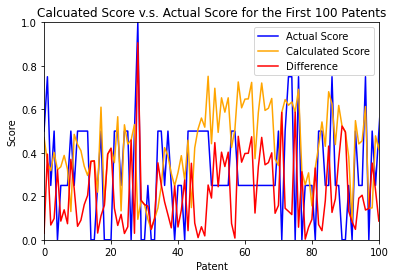

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num = list(range(0,len(scoreArr)))

f = plt.figure()
#f.set_figwidth(500)
#f.set_figheight(100)

fix, ax = plt.subplots()
plt.plot(num, scoreArr, color='b', label='Actual Score')
plt.plot(num, embedScoreArr, color='orange', label='Calculated Score')
plt.plot(num, abs(scoreArr - embedScoreArr), color = 'r', label = 'Difference')

plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 100])
plt.ylabel('Score')
plt.xlabel('Patent')
plt.title('Calcuated Score v.s. Actual Score for the First 100 Patents')
plt.show()

Correlation:

In [ ]:
corr = jnp.corrcoef(embedScoreArr, scoreArr)
print("correlation between the calculated score and the given score = " + str(corr[0][1]))

correlation between the calculated score and the given score = 0.27611968


Normal Distribution of the Score Data


In [ ]:
#Round values from https://www.kaggle.com/code/brunogianesi/patent-phrase-to-phrase-matching-baseline

def round_values(x):
    if x >= 0 and x < 0.125:
        return 0
    if x >= 0.125 and x < 0.375:
        return 0.25
    if x >= 0.375 and x < 0.625:
        return 0.5
    if x >= 0.625 and x < 0.875:
        return 0.75
    if x >= 0.875 and x <= 1:
        return 1.0

In [ ]:
scoreRound = {'0': 0, '0.25': 0, '0.5': 0, '0.75': 0, '1.0': 0}
scoreTotal = 0

for i in scoreArr:
  scoreTotal += i
  if str(i) in scoreRound:
    scoreRound[str(i)] += 1
  else:
    scoreRound[str(i)] = 1
print("Rounded Actual Scores: ")
print(scoreRound)

scoreRoundProb = {}

for i in scoreRound:
  scoreRoundProb[i] = scoreRound[i] / len(scoreArr)

print("Score Probabilities: ")
print(scoreRoundProb)

scoreMean = scoreTotal / len(scoreArr)
print("Actual Score Mean = " + str(scoreMean))

Rounded Actual Scores: 
{'0': 0, '0.25': 11519, '0.5': 12300, '0.75': 4029, '1.0': 1154, '0.0': 7471}
Score Probabilities: 
{'0': 0.0, '0.25': 0.3158226633400049, '0.5': 0.33723576344144984, '0.75': 0.11046527568338223, '1.0': 0.03163984317166123, '0.0': 0.20483645436350176}
Actual Score Mean = 0.36206234


In [ ]:
embedScoreRound = {'0': 0, '0.25': 0, '0.5': 0, '0.75': 0, '1.0': 0}
embedScoreTotal = 0

for i in embedScoreArr:
  embedScoreTotal += i
  if str(i) in embedScoreRound:
    embedScoreRound[str(i)] += 1
  else:
    embedScoreRound[str(i)] = 1
print("Rounded Calculated Scores: ")
print(embedScoreRound)

embedScoreRoundProb = {}

for i in embedScoreRound:
  embedScoreRoundProb[i] = embedScoreRound[i] / len(embedScoreArr)

print("Calculated Score Probabilities: ")
print(embedScoreRoundProb)
embedScoreMean = embedScoreTotal / len(embedScoreArr)
print("Calculated Score Mean = " + str(embedScoreMean))

Rounded Calculated Scores: 
{'0': 0, '0.25': 41, '0.5': 77, '0.75': 47, '1.0': 0, '0.47': 60, '0.356': 54, '0.318': 59, '0.402': 55, '0.322': 46, '0.336': 55, '0.388': 63, '0.324': 47, '0.13': 10, '0.485': 90, '0.438': 65, '0.41': 59, '0.338': 51, '0.296': 40, '0.361': 58, '0.363': 73, '0.219': 29, '0.61': 63, '0.158': 17, '0.394': 62, '0.421': 62, '0.355': 74, '0.566': 78, '0.133': 13, '0.529': 91, '0.44': 66, '0.459': 63, '0.53': 82, '0.094': 18, '0.181': 17, '0.162': 17, '0.095': 13, '0.048': 10, '0.098': 7, '0.146': 25, '0.247': 39, '0.424': 72, '0.385': 46, '0.305': 46, '0.248': 39, '0.309': 35, '0.387': 53, '0.275': 39, '0.458': 70, '0.148': 15, '0.423': 67, '0.51': 73, '0.56': 89, '0.518': 75, '0.752': 32, '0.442': 62, '0.697': 53, '0.494': 77, '0.653': 59, '0.587': 64, '0.425': 69, '0.508': 68, '0.726': 45, '0.607': 61, '0.647': 59, '0.648': 62, '0.724': 39, '0.373': 58, '0.586': 77, '0.721': 30, '0.595': 82, '0.605': 76, '0.65': 60, '0.372': 45, '0.342': 59, '0.645': 62, '0.61

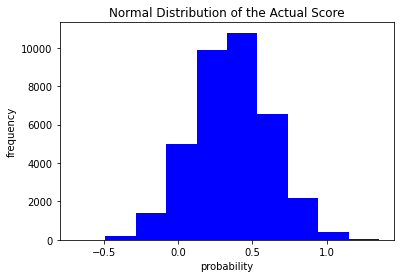

In [ ]:
stdScore = jnp.std(scoreArr)
scoreDis = np.random.normal(scoreMean, stdScore, len(scoreArr))
plt.xlabel('probability')
plt.ylabel('frequency')
plt.title('Normal Distribution of the Actual Score')
plt.hist(scoreDis,color='b')
plt.show() 

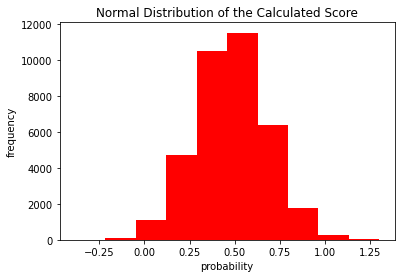

In [ ]:
stdEmbedScore = jnp.std(embedScoreArr)
embedScoreDis = np.random.normal(embedScoreMean, stdEmbedScore, len(embedScoreArr))
plt.xlabel('probability')
plt.ylabel('frequency')
plt.title('Normal Distribution of the Calculated Score')
plt.hist(embedScoreDis, color='r')
plt.show() 

In [ ]:
corr = jnp.corrcoef(embedScoreDis, jnp.array(train_df['score']))
print("correlation between the calculated score and the given score = " + str(corr[0][1]))

correlation between the calculated score and the given score = -4.5558627e-06
